# Pokigen
This code uses a beta variational auto encoder [B.1] to generate pokemon like images.

In [1]:
import sys
sys.path.append("../src")
import matplotlib.pyplot as plt
import cv2
import tensorflow
import os
import numpy as np
from tensorflow.keras.layers import Dense, Conv2D, Conv2DTranspose, Input, MaxPool2D, Flatten, UpSampling2D, Reshape
from tensorflow.keras.models import Model

# Choose your destiny
# Full virgin CNN_beta_VAE net
#from cnn_beta_vae import CNNBetaVAE
# Light virgin CNN_beta_VAE net
from cnn_beta_vae_light import CNNBetaVAE
# Mobilenet based CNN_beta_VAE net
#from cnn_beta_vae_mobilenet import CNNBetaVAE

# CNN BVAE Building and preparing
Verify that the models folder exists

In [2]:
if not os.path.exists("../models"):
    os.mkdir("../models")
    print("Models dir was not found. Created")

Let's create the network

In [3]:
cnnbvae = CNNBetaVAE((128,128,3),2,0.002, model_weights_path="../models/model.h5")

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 64) 1792        input[0][0]                      
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 128, 128, 64) 256         conv2d[0][0]                     
__________________________________________________________________________________________________
tf_op_layer_Relu (TensorFlowOpL multiple             0           batch_normalization[0][0]        
____________________________________________________________________________________________

# Reloading weights (if not a new training)

In [4]:
# Load models if you want tyo start from previous training otherwize please skip
cnnbvae.load_weights("../models/model_weights.h5")

# Database import
If the database was not added to your dir. Please use those lines to download and install it.

This was tested on Ubuntu PC using bash shell.
If you are using windows, you may need to change some shell commands to dos style ones. 

In [44]:
# Download the pokemon database from rileynwong's github
!wget https://github.com/rileynwong/pokemon-images-dataset-by-type/archive/master.zip
# Extract and select the all subdatabase 
!unzip master.zip 
!mv pokemon-images-dataset-by-type-master/all ../database
# Remove resulting files
!rm -R pokemon-images-dataset-by-type-master
!rm master.zip

--2020-10-25 10:22:05--  https://github.com/rileynwong/pokemon-images-dataset-by-type/archive/master.zip
Résolution de github.com (github.com)… 140.82.121.3
Connexion à github.com (github.com)|140.82.121.3|:443… connecté.
requête HTTP transmise, en attente de la réponse… 302 Found
Emplacement : https://codeload.github.com/rileynwong/pokemon-images-dataset-by-type/zip/master [suivant]
--2020-10-25 10:22:05--  https://codeload.github.com/rileynwong/pokemon-images-dataset-by-type/zip/master
Résolution de codeload.github.com (codeload.github.com)… 140.82.121.10
Connexion à codeload.github.com (codeload.github.com)|140.82.121.10|:443… connecté.
requête HTTP transmise, en attente de la réponse… 200 OK
Taille : non indiqué [application/zip]
Enregistre : «master.zip»

master.zip              [  <=>               ]   4,99M  12,5MB/s    ds 0,4s    

2020-10-25 10:22:05 (12,5 MB/s) - «master.zip» enregistré [5227888]

Archive:  master.zip
5efee999701bf26a73216c0f6f35aa9968cd1fd9
   creating: poke

  inflating: pokemon-images-dataset-by-type-master/all/slowpoke.png  
  inflating: pokemon-images-dataset-by-type-master/all/slugma.png  
  inflating: pokemon-images-dataset-by-type-master/all/slurpuff.png  
  inflating: pokemon-images-dataset-by-type-master/all/smeargle.png  
  inflating: pokemon-images-dataset-by-type-master/all/smoochum.png  
  inflating: pokemon-images-dataset-by-type-master/all/sneasel.png  
  inflating: pokemon-images-dataset-by-type-master/all/snivy.png  
  inflating: pokemon-images-dataset-by-type-master/all/snorlax.png  
  inflating: pokemon-images-dataset-by-type-master/all/snorunt.png  
  inflating: pokemon-images-dataset-by-type-master/all/snover.png  
  inflating: pokemon-images-dataset-by-type-master/all/snubbull.png  
  inflating: pokemon-images-dataset-by-type-master/all/solgaleo.jpg  
  inflating: pokemon-images-dataset-by-type-master/all/solosis.png  
  inflating: pokemon-images-dataset-by-type-master/all/solrock.png  
  inflating: pokemon-images-data

 extracting: pokemon-images-dataset-by-type-master/poison/dragalge.png  
  inflating: pokemon-images-dataset-by-type-master/poison/drapion.png  
  inflating: pokemon-images-dataset-by-type-master/poison/ekans.png  
  inflating: pokemon-images-dataset-by-type-master/poison/garbodor.png  
  inflating: pokemon-images-dataset-by-type-master/poison/golbat.png  
  inflating: pokemon-images-dataset-by-type-master/poison/grimer.png  
  inflating: pokemon-images-dataset-by-type-master/poison/gulpin.png  
  inflating: pokemon-images-dataset-by-type-master/poison/koffing.png  
  inflating: pokemon-images-dataset-by-type-master/poison/mareanie.png  
  inflating: pokemon-images-dataset-by-type-master/poison/muk.png  
  inflating: pokemon-images-dataset-by-type-master/poison/naganadel.png  
  inflating: pokemon-images-dataset-by-type-master/poison/nidoking.png  
  inflating: pokemon-images-dataset-by-type-master/poison/nidoqueen.png  
  inflating: pokemon-images-dataset-by-type-master/poison/nidoran

In [5]:
# The database is ready, let's load it and preprocess it
db = "../database"
# Load training/validation database and preprocess it
images, pokemons_files = cnnbvae.load_images(db, return_image_file_names=True)
# Preprocess data
images = cnnbvae.preprocess_images(images)

In [6]:
def show_photos(img_vals, image_names, nb_columns=4, figsize=(10,20), max_nbphotos=12):
    fig = plt.figure(figsize=figsize)
    nb_rows = len(image_names)//nb_columns+1

    if len(image_names)>max_nbphotos:
        nb_files= max_nbphotos
    else:
        nb_files=len(image_names)

    for i in range(nb_files):
        img =plt.subplot(nb_files,nb_columns,i+1)
        img.imshow((img_vals[i,:,:]))
        img.set_title(image_names[i])
    plt.tight_layout()

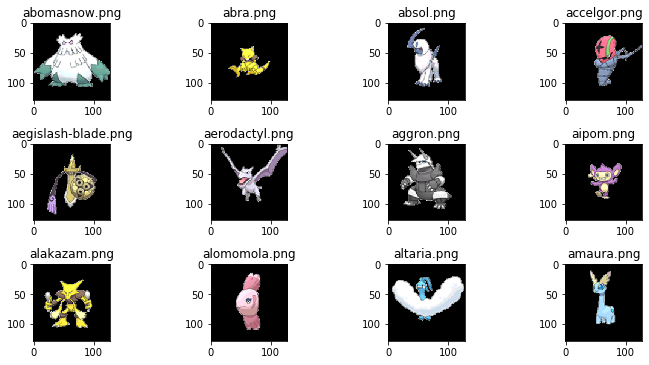

In [7]:
show_photos(images, pokemons_files)

In [6]:
print(images.dtype)
cnnbvae.learn(images,100)

float32
Fitting auto encoder
Train on 647 samples, validate on 162 samples
Epoch 1/100
647/647 [==============================] - ETA: 0s - loss: 15223.0994WARNING:tensorflow:From /home/aloui/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training_v1.py:2048: Model.state_updates (from tensorflow.python.keras.engine.training) is deprecated and will be removed in a future version.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
647/647 [==============================] - 214s 331ms/sample - loss: 15223.0994 - val_loss: 15759.2966
Epoch 2/100
647/647 [==============================] - 211s 326ms/sample - loss: 10657.6716 - val_loss: 6658.7734
Epoch 3/100
647/647 [==============================] - 218s 337ms/sample - loss: 7432.9044 - val_loss: 5015.4366
Epoch 4/100
647/647 [==============================] - 212s 328ms/sample - loss: 11442.3259 - val_loss: 1858.6012
Epoch 5/100
647/647 [=================

KeyboardInterrupt: 

Text(0.5, 1.0, 'Loss curves')

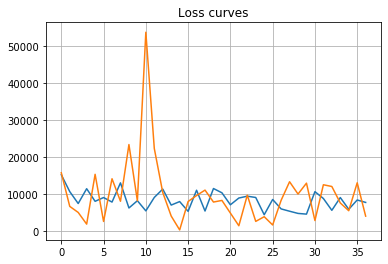

In [8]:
plt.figure()
plt.grid()
plt.plot(cnnbvae.loss_buffer, label="Loss")
plt.plot(cnnbvae.val_loss_buffer, label="Validation Loss")
plt.title("Loss curves")


In [13]:
out = cnnbvae.predict(images)

0.06718838
1.3887072e-07


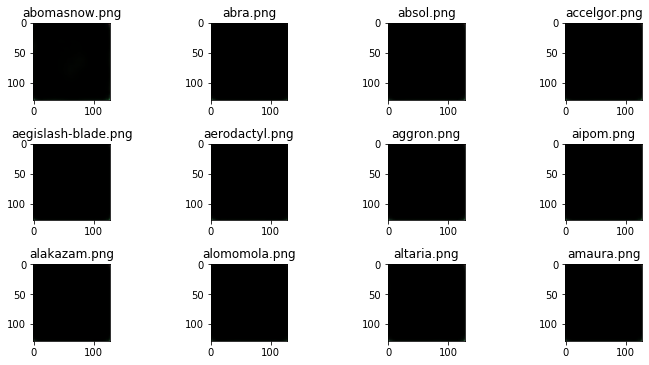

In [14]:
out_images = cnnbvae.postprocess_outputs(out).astype(np.int)
show_photos(out*10, pokemons_files)
print(out.max())
print(out.min())

(809, 2)


ValueError: x and y must be the same size

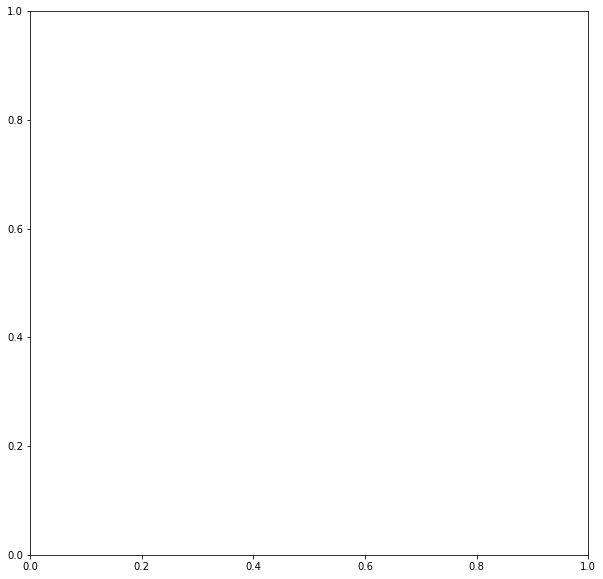

In [10]:
fig = plt.figure(figsize=(10,10))
out = cnnbvae.encoder.predict(images)[2]
print(out.shape)
for i in range(len(pokemons_files)):
    plt.scatter(out[:,0],[0])


In [18]:
bvae.save("../models/model_final.h5")

In [15]:
img = bvae.decoder.predict([0.5])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

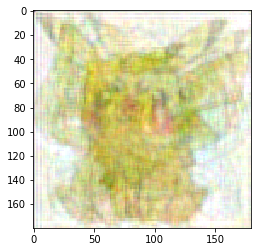

In [16]:
import numpy as np
import matplotlib.pyplot as plt

from matplotlib import animation, rc
from IPython.display import HTML

im = bvae.decoder.predict([np.arange(-2,2,0.01)])

fig, ax = plt.subplots()

line = ax.imshow(np.zeros((180,180,3)))
# initialization function: plot the background of each frame
def init():
    line.set_data(np.zeros((180,180,3)))
    return (line,)

def animate(i):
    line.set_data(im[i,:,:,:])
    return (line,)
anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=im.shape[0], interval=200, blit=True)
HTML(anim.to_html5_video())



# Bibliography
 - B.1 Higgins, I. et al. “beta-VAE: Learning Basic Visual Concepts with a Constrained Variational Framework.” ICLR (2017).